In [1]:
import gymnasium as gym
from vectorhash import build_vectorhash_architecture
from shifts import RatShift
from smoothing import RatSLAMSmoothing
import miniworld
from miniworld.params import DEFAULT_PARAMS
from miniworld_agent import MiniworldVectorhashAgent
import math
import torch
from graph_utils import plot_imgs_side_by_side
from matplotlib import pyplot as plt
from graph_utils import error_test
import copy


### vhash
device = "cuda"
shapes = [(5, 5, 5), (8, 8, 8)]
N = 10


def make_env():
    params = DEFAULT_PARAMS.copy().no_random()
    # [
    #     "MiniWorld-CollectHealth-v0",
    #     "MiniWorld-FourRooms-v0",
    #     "MiniWorld-Hallway-v0",
    #     "MiniWorld-Maze-v0",
    #     "MiniWorld-MazeS2-v0",
    #     "MiniWorld-MazeS3-v0",
    #     "MiniWorld-MazeS3Fast-v0",
    #     "MiniWorld-OneRoom-v0",
    #     "MiniWorld-OneRoomS6-v0",
    #     "MiniWorld-OneRoomS6Fast-v0",
    #     "MiniWorld-PickupObjects-v0",
    #     "MiniWorld-PutNext-v0",
    #     "MiniWorld-RoomObjects-v0",
    #     "MiniWorld-Sidewalk-v0",
    #     "MiniWorld-Sign-v0",
    #     "MiniWorld-TMaze-v0",
    #     "MiniWorld-TMazeLeft-v0",
    #     "MiniWorld-TMazeRight-v0",
    #     "MiniWorld-ThreeRooms-v0",
    #     "MiniWorld-WallGap-v0",
    #     "MiniWorld-YMaze-v0",
    #     "MiniWorld-YMazeLeft-v0",
    #     "MiniWorld-YMazeRight-v0",
    # ]
    env = gym.make(
        "MiniWorld-CollectHealth-v0",
        max_episode_steps=-1,
        params=params,
        domain_rand=False,
    )
    min_x = env.get_wrapper_attr("min_x")
    max_x = env.get_wrapper_attr("max_x")
    min_z = env.get_wrapper_attr("min_z")
    max_z = env.get_wrapper_attr("max_z")

    limits = torch.tensor([max_x - min_x, max_z - min_z, 2 * math.pi]).float()
    return env, limits


env, limits = make_env()
model = build_vectorhash_architecture(
    shapes,
    N_h=600,
    input_size=60 * 80,
    initalization_method="by_sparsity",
    limits=limits,
    device=device,
    shift=RatShift(),
    smoothing=RatSLAMSmoothing(device=device),
)


#### agent
agent = MiniworldVectorhashAgent(model, env)

by_sparsity
module shapes:  [(5, 5, 5), (8, 8, 8)]
N_g     :  637
N_patts :  64000
N_h     :  600


/home/ezrahuang/Projects/rl-research/vectorhash/hippocampal_sensory_layers.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  1 + input.T @ self.inhibition_matrix_hs @ input
/home/ezrahuang/miniconda3/envs/ml/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


info for each h directly after learning it
h max, min, mean tensor(6.3049, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7518, device='cuda:0')
h_from_s max, min, mean tensor(6.3049, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7518, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0017, device='cuda:0') tensor(1.3620, device='cuda:0') tensor(1.7179, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(537, device='cuda:0') tensor(537, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(537, device='cuda:0') tensor(537, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(9.9725e-11, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.5428, device='cuda:0') tensor([0.8163], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(2.6536e-10, device='cuda:0') ten

/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:102: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:109: UserWarning: Using a target size (torch.Size([1, 600])) that is different to the input size (torch.Size([600])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(h, h_from_s_denoised),
/home/ezrahuang/Projects/rl-research/vectorhash/vectorhash.py:125: UserWarning: Using a target size (torch.Size([1, 4800])) that is different to the input size (torch.Size([4800])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(s, s_from_h_from_s)

In [2]:
start_state = agent.vectorhash.scaffold.g
print('start state:', start_state)
print('grid limits:', agent.vectorhash.scaffold.grid_limits)
print('world limits:', limits)
print('scale factor:', agent.vectorhash.scaffold.scale_factor)

start state: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.,

In [3]:
begin = agent.get_true_pos(env)
end = begin + 1 / agent.vectorhash.scaffold.scale_factor
dist = torch.distributions.uniform.Uniform(low=begin, high=end)
samples = dist.sample((N,))
grid_states = agent.vectorhash.scaffold.scale_factor * (samples - begin)

In [4]:
print("samples:", samples)
print("grid states:", grid_states)

samples: tensor([[5.5766, 4.6832, 1.5030],
        [5.7643, 4.9309, 1.5645],
        [5.5653, 4.9917, 1.5051],
        [5.6818, 4.9787, 1.4447],
        [5.6126, 4.8168, 1.5889],
        [5.6931, 4.8872, 1.4577],
        [5.5521, 4.7872, 1.4730],
        [5.6327, 4.9548, 1.5436],
        [5.8764, 4.8770, 1.4903],
        [5.6190, 4.9800, 1.4552]], device='cuda:0')
grid states: tensor([[0.0680, 0.0711, 0.4335],
        [0.5374, 0.6903, 0.8247],
        [0.0397, 0.8425, 0.4468],
        [0.3311, 0.8100, 0.0620],
        [0.1581, 0.4051, 0.9801],
        [0.3592, 0.5812, 0.1448],
        [0.0069, 0.3311, 0.2424],
        [0.2083, 0.7502, 0.6919],
        [0.8176, 0.5558, 0.3525],
        [0.1741, 0.8132, 0.1294]], device='cuda:0')


info for each h directly after learning it
h max, min, mean tensor(6.3049, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7518, device='cuda:0')
h_from_s max, min, mean tensor(6.3049, device='cuda:0') tensor(0., device='cuda:0') tensor(1.7518, device='cuda:0')
h_from_s_denoised max, min, mean tensor(2.0017, device='cuda:0') tensor(1.3620, device='cuda:0') tensor(1.7179, device='cuda:0')
avg nonzero/greaterzero h from book: tensor(537, device='cuda:0') tensor(537, device='cuda:0')
avg nonzero/greaterzero h from s: tensor(537, device='cuda:0') tensor(537, device='cuda:0')
avg nonzero/greaterzero h from s denoised: tensor(600, device='cuda:0') tensor(600, device='cuda:0')
mse/cosinesimilarity h from book and h from s tensor(1.0418e-11, device='cuda:0') tensor([1.], device='cuda:0')
mse/cosinesimilarity h from book and h from s denoised tensor(1.5428, device='cuda:0') tensor([0.8163], device='cuda:0')
mse/cosinesimilarity s and s from h from s tensor(0.0005, device='cuda:0') tensor(

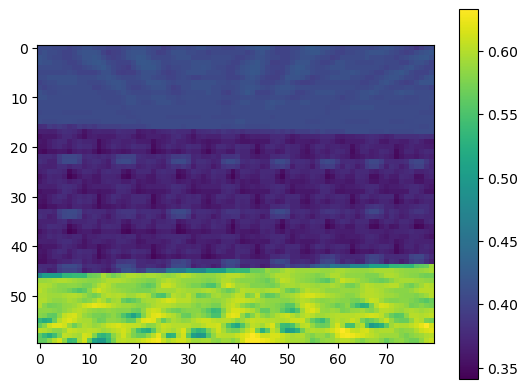

In [5]:
first_img, first_pos = agent._env_reset(env)
first_img, first_pos = agent._obs_postpreprocess(agent.env.step(4), 4)
m = plt.imshow(first_img)
plt.colorbar(m)
agent.vectorhash.store_memory(s=first_img.flatten().to(device))

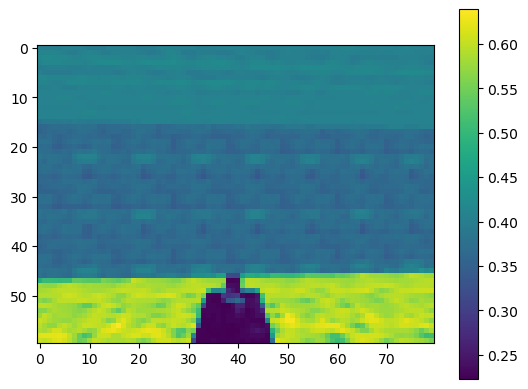

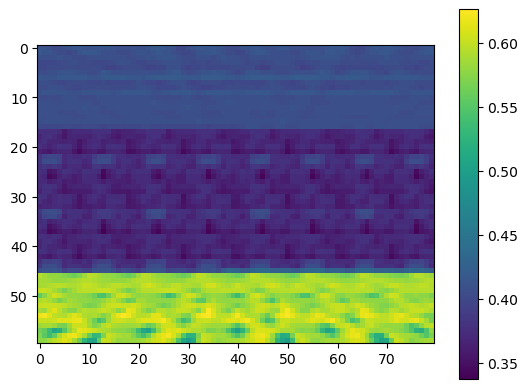

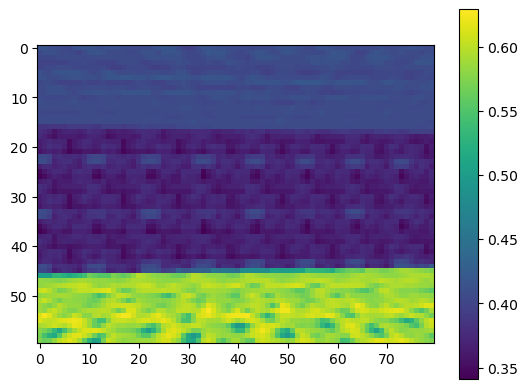

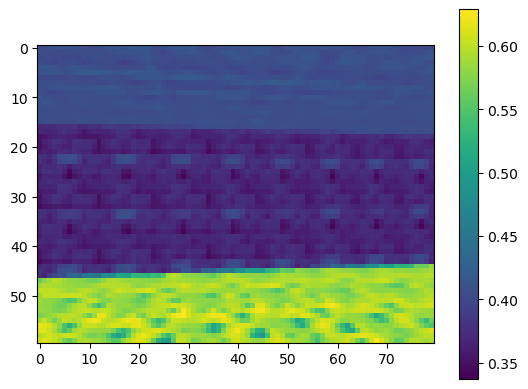

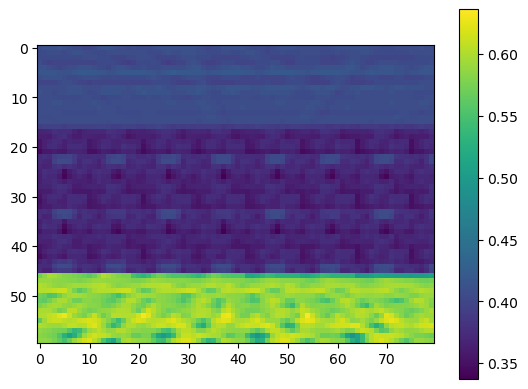

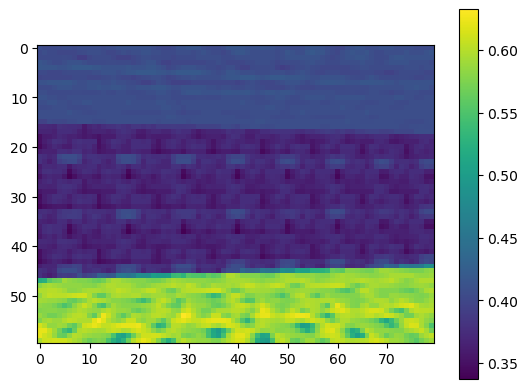

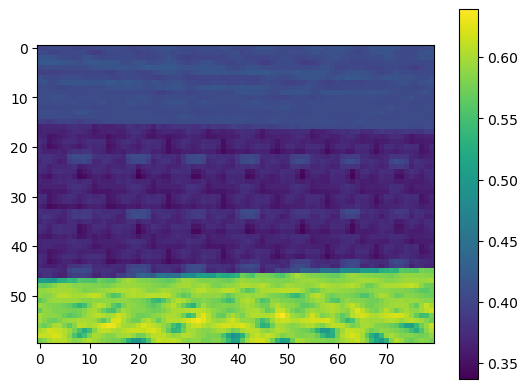

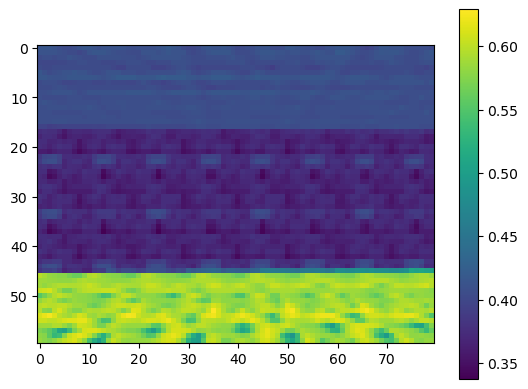

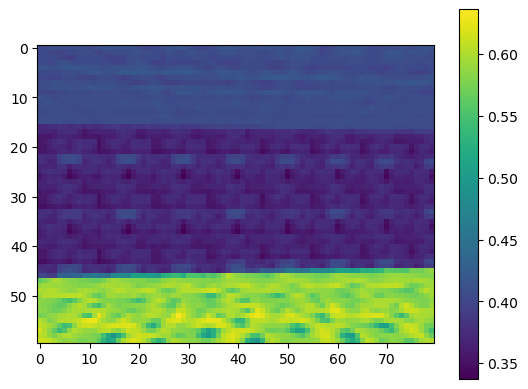

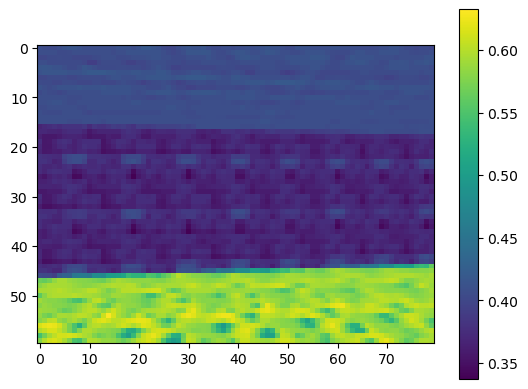

In [6]:
imgs = []
states = []
for sample in samples:
    pos = sample.cpu().numpy()
    agent.set_agent_pos(pos)
    img , _ = agent._obs_postpreprocess(agent.env.step(4), 4)
    obs = img.flatten().to(device)
    g = agent.vectorhash.scaffold.denoise(
        agent.vectorhash.scaffold.grid_from_hippocampal(
            agent.vectorhash.hippocampal_sensory_layer.hippocampal_from_sensory(obs)
        )
    )
    m = plt.imshow(img)
    plt.colorbar(m)
    plt.show()
    imgs.append(img)
    states.append(g)

In [7]:
print(states)

[tensor([[0.0097, 0.0080, 0.0078, 0.0080, 0.0079, 0.0079, 0.0083, 0.0084, 0.0077,
         0.0078, 0.0080, 0.0081, 0.0080, 0.0083, 0.0078, 0.0082, 0.0079, 0.0078,
         0.0080, 0.0084, 0.0081, 0.0078, 0.0081, 0.0075, 0.0081, 0.0081, 0.0083,
         0.0080, 0.0082, 0.0081, 0.0079, 0.0082, 0.0079, 0.0084, 0.0079, 0.0081,
         0.0080, 0.0082, 0.0083, 0.0079, 0.0079, 0.0077, 0.0081, 0.0079, 0.0079,
         0.0079, 0.0080, 0.0084, 0.0083, 0.0078, 0.0082, 0.0079, 0.0079, 0.0082,
         0.0083, 0.0080, 0.0076, 0.0080, 0.0081, 0.0080, 0.0079, 0.0083, 0.0079,
         0.0076, 0.0084, 0.0080, 0.0078, 0.0081, 0.0079, 0.0079, 0.0079, 0.0080,
         0.0080, 0.0080, 0.0082, 0.0082, 0.0078, 0.0079, 0.0079, 0.0079, 0.0082,
         0.0077, 0.0081, 0.0078, 0.0079, 0.0079, 0.0082, 0.0080, 0.0078, 0.0078,
         0.0079, 0.0079, 0.0078, 0.0081, 0.0074, 0.0078, 0.0082, 0.0077, 0.0080,
         0.0081, 0.0079, 0.0080, 0.0081, 0.0080, 0.0076, 0.0077, 0.0081, 0.0079,
         0.0079, 0.0081, 0.

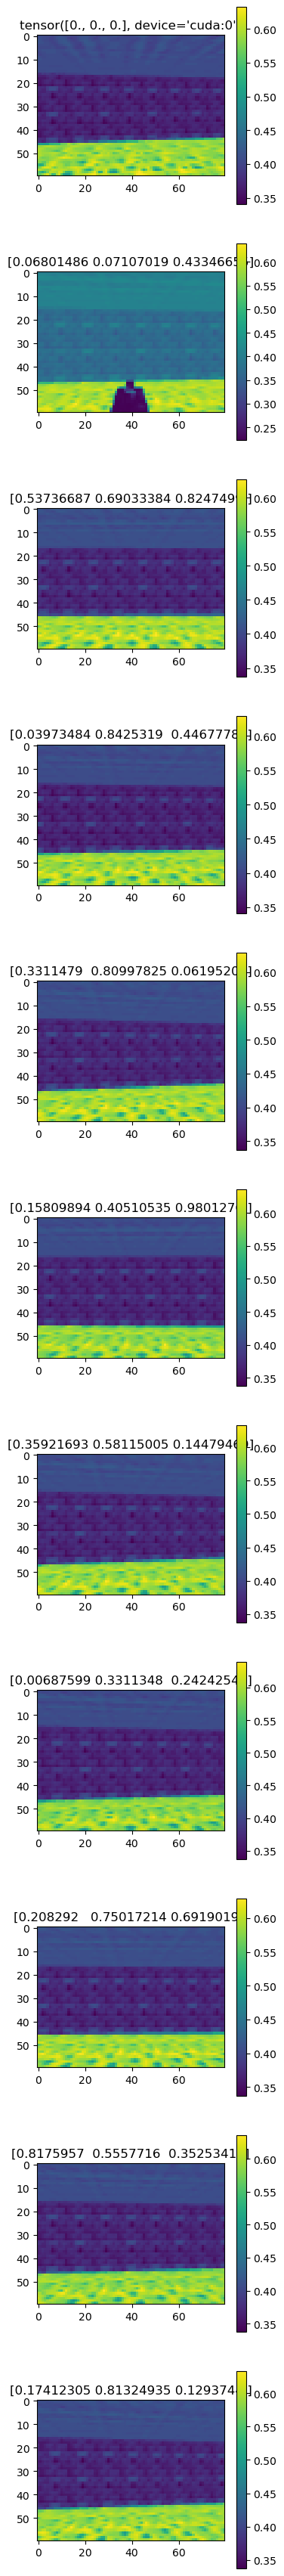

In [8]:
fig, axs = plt.subplots(nrows=N + 1, figsize=(4, 4 * (N + 1)))

plot_imgs_side_by_side(
    [first_img] + imgs,
    axs,
    [f"{first_pos - first_pos}"]
    + [
        f"{(p - begin).cpu().numpy() * model.scaffold.scale_factor.cpu().numpy()}"
        for p in samples
    ],
    fig,
    use_first_img_scale=False,
)

In [9]:
errors = torch.zeros(N, 3)

scaffold_copy = copy.deepcopy(model.scaffold)
for i, state in enumerate(states):
  scaffold_copy.modules = scaffold_copy.modules_from_g(state[0])
  for d in range(3):
    errors[i, d] = error_test(0, scaffold_copy.expand_distribution(d))

In [10]:
print(errors)

tensor([[10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995],
        [10.0127, 10.0128,  9.9995]])
